In [385]:
## Importing Packages

import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import keras
from tensorflow.python.framework import ops
from utils import *
import random
import pandas as pd
import os

In [386]:
data_path = r"Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\testData.mat"
mechFreq, optFreq, mechQ, optQ, paramsMat = load_data(data_path)

paramsShape = np.shape(paramsMat)[:-1]
num_examples = np.shape(paramsMat)[-1]
optQ_linearized = np.log10(optQ)

paramsMat_transposed = tf.transpose(paramsMat, perm = [3, 0, 1, 2])
print("shape of paramsMat_transposed: \t", np.shape(paramsMat_transposed))

print("shape of optQ: \t", np.shape(optQ))

print("number of training examples: \t", num_examples)

Loading data from:  Z:\srobison\Simulation\COMSOL\DeepLearning_vNew\DataManager\testData.mat 

shape of paramsMat_transposed: 	 (911, 11, 18, 3)
shape of optQ: 	 (911, 1)
number of training examples: 	 911


In [387]:
dataset = tf.data.Dataset.from_tensor_slices((paramsMat_transposed, optQ_linearized))

# Shuffle and split the dataset
train_size = int(0.8 * num_examples)
train_dataset = dataset.shuffle(buffer_size=num_examples).take(train_size)
test_dataset = dataset.skip(train_size)

# Example of batching the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [2]:
def identity_block(X, f, filters, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    ## Set the padding = 'same'
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X) 

    ## Third component of main path (≈2 lines)
    ## Set the padding = 'valid'
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X) 
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X

In [3]:
# UNQ_C2
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='same')(X)
    X = BatchNormalization(axis = 3)(X)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='same')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


In [56]:
# UNQ_C3
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (11, 19, 3), training=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # # Zero-Padding
    # X = ZeroPadding2D((2, 2))(X_input)
    
    # Stage 1
    X = Conv2D(64, (3, 3), strides = (2, 2), padding='same')(X_input)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    # X = MaxPooling2D((2, 2), strides=(2, 2),padding='same')(X)

    
    X = Dropout(0.15)(X)
    
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 64], s = 1)
    X = identity_block(X, 3, [32, 32, 64])
    X = identity_block(X, 3, [32, 32, 64])

    ### START CODE HERE
    
    # Use the instructions above in order to implement all of the Stages below
    # Make sure you don't miss adding any required parameter
    
    ## Stage 3 (≈4 lines)
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 2, filters = [32, 32, 64], s = 2)
    
    
    # the 3 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 2, [32, 32, 64])
    # X = identity_block(X, 3, [128, 128, 512])
    # X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [32, 32, 64], s = 2)
   
    # the 5 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [32, 32, 64])
    # X = identity_block(X, 3, [256, 256, 1024])
    # X = identity_block(X, 3, [256, 256, 1024])
    # X = identity_block(X, 3, [256, 256, 1024])
    # X = identity_block(X, 3, [256, 256, 1024])

    # # Stage 5 (≈3 lines)
    # # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    # X = convolutional_block(X, f = 4, filters = [32, 32, 64], s = 2)
    
    # # the 2 `identity_block` with correct values of `f` and `filters` for this stage
    # X = identity_block(X, 4, [32, 32, 64])
    # # X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D()(X)"
    X = AveragePooling2D((2, 2), padding='same')(X)
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(32, activation='relu')(X)
    X = Dense(1)(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [65]:
res_model = ResNet50(paramsShape)
optimizer = keras.optimizers.Adam(learning_rate = 0.0005)
res_model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics =['mse'])

res_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)   │ (None, 11, 18, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_460 (Conv2D)           │ (None, 6, 9, 64)          │           1,792 │ input_layer_15[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_459       │ (None, 6, 9, 64)          │             256 │ conv2d_460[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_412 (Activation)   │ (None, 6, 9, 64)          │               0 │ batch_normalization_459[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 6, 9, 64)          │               0 │ activation_412[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_461 (Conv2D)           │ (None, 6, 9, 32)          │           2,080 │ dropout_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_460       │ (None, 6, 9, 32)          │             128 │ conv2d_461[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_413 (Activation)   │ (None, 6, 9, 32)          │               0 │ batch_normalization_460[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_462 (Conv2D)           │ (None, 6, 9, 32)          │           9,248 │ activation_413[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_461       │ (None, 6, 9, 32)          │             128 │ conv2d_462[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_414 (Activation)   │ (None, 6, 9, 32)          │               0 │ batch_normalization_461[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_463 (Conv2D)           │ (None, 6, 9, 64)          │           2,112 │ activation_414[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_464 (Conv2D)           │ (None, 6, 9, 64)          │           4,160 │ dropout_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_462       │ (None, 6, 9, 64)          │             256 │ conv2d_463[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_463       │ (None, 6, 9, 64)          │             256 │ conv2d_464[0][0]           │
│ (BatchNormalization)          │                           │               

 Total params: 106,881 (417.50 KB)

 Trainable params: 104,577 (408.50 KB)

 Non-trainable params: 2,304 (9.00 KB)

In [394]:
res_model = OMC_ResNet_hyperParamed(hParams, paramsShape)
optimizer = keras.optimizers.Adam(learning_rate = learnRate)
res_model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics =['mse'])
history = res_model.fit(train_dataset, epochs=250, validation_data=test_dataset,verbose=1)
performance = res_model.evaluate(test_dataset)

Epoch 1/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 9.2996 - mse: 9.2996 - val_loss: 14.2008 - val_mse: 14.2008
Epoch 2/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.3249 - mse: 0.3249 - val_loss: 12.9791 - val_mse: 12.9791
Epoch 3/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.2420 - mse: 0.2420 - val_loss: 11.9868 - val_mse: 11.9868
Epoch 4/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1959 - mse: 0.1959 - val_loss: 11.0356 - val_mse: 11.0356
Epoch 5/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1722 - mse: 0.1722 - val_loss: 10.1311 - val_mse: 10.1311
Epoch 6/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1701 - mse: 0.1701 - val_loss: 9.4104 - val_mse: 9.4104
Epoch 7/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1539 - mse: 0.1539 - val_loss: 8.7419 - val_mse: 8.7419
Epoch 8/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1618 - mse: 0.1618 - val_loss: 8.4431 - val_mse: 8.4431
Epoch 9/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms

In [398]:
history = res_model.fit(train_dataset, epochs=250, validation_data=test_dataset,verbose=1)
performance = res_model.evaluate(test_dataset)

Epoch 1/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 2/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 3/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 4/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 5/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 6/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 7/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 8/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 9/250
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - lo

Index(['loss', 'mse', 'val_loss', 'val_mse'], dtype='object')


C:\Users\LINQS--SQUEEZING\AppData\Local\Temp\ipykernel_13108\4250672253.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\LINQS--SQUEEZING\AppData\Local\Temp\ipykernel_13108\4250672253.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)


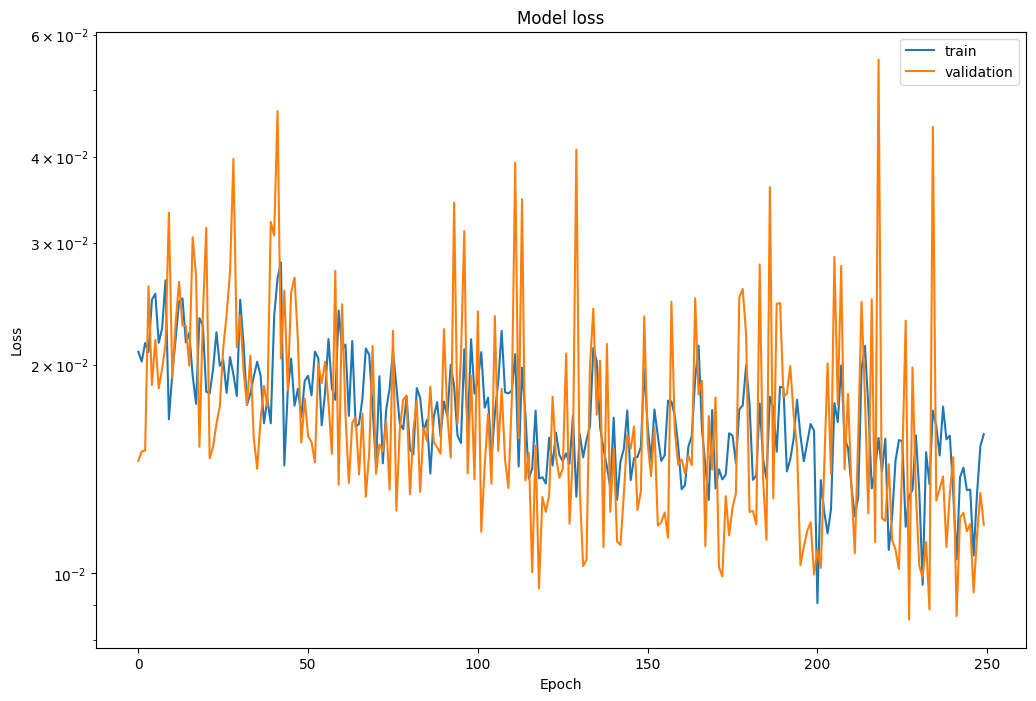

In [397]:
df_loss_acc = pd.DataFrame(history.history)
print(df_loss_acc.columns)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_mse= df_loss_acc[['mse','val_mse']]
df_mse.rename(columns={'mse':'train','val_mse':'validation'},inplace=True)

df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
plt.yscale('log')
# df_mse.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='MSE')

In [88]:

numBlocks = 3
Conv1Params = [64, 2, 3]
MP1params = [False, 2, 2]
CB1params = [2, 32, 32, 64, 3]
IDB1params = [3, 32, 32, 64]
CB2params = [2, 32, 32, 64, 3]
IDB2params = [3, 32, 32, 64]
CB3params = [2, 32, 32, 64, 3]
IDB3params = [3, 32, 32, 64]
APparams = [True, 2, True]
FCparams =  32
DropoutParams = [1, 0.1]
learnRate = 0.0005;

hParams = {
    "numBlocks": numBlocks,
    "Conv1Params": Conv1Params,
    "MP1params": MP1params,
    "CB1params": CB1params,
    "IDB1params": IDB1params,
    "CB2params": CB2params,
    "IDB2params": IDB2params,
    "CB3params": CB3params,
    "IDB3params": IDB3params,
    "APparams": APparams,
    "FCparams": FCparams,
    "DropoutParams": DropoutParams,
    "learnRate": learnRate
}


In [353]:
# UNQ_C3
# GRADED FUNCTION: ResNet50

def OMC_ResNet_hyperParamed(hParams, input_shape = (11, 19, 3), training=False):
    

    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # # Zero-Padding
    # X = ZeroPadding2D((2, 2))(X_input)

    DropoutParams = hParams["DropoutParams"]
    numDrop = DropoutParams[0]
    dropRate = DropoutParams[1]
    numBlocks = hParams["numBlocks"]
    
    conv1Params = hParams["Conv1Params"]
    numFilt = conv1Params[0]
    fSize = conv1Params[1]
    stride = conv1Params[2]
    # Stage 1
    X = Conv2D(numFilt, (fSize, fSize), strides = (stride, stride), padding='same')(X_input)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    MP1params = hParams["MP1params"]
    if MP1params[0]:
        fSize = MP1params[1]
        stride = MP1params[2]
        X = MaxPooling2D((fSize, fSize), strides=(stride,stride),padding='same')(X)

    if numDrop == 1:
        X = Dropout(dropRate)(X)



    CBparams = hParams["CB1params"]
    IDBparams = hParams["IDB1params"] 


    # Stage 2
    fSize = CBparams[0]
    numFilt1 = CBparams[1]
    numFilt2 = CBparams[2]
    numFilt3 = CBparams[3]
    stride = CBparams[4]
    X = convolutional_block(X, f = fSize, filters = [numFilt1, numFilt2, numFilt3], s = stride)


    fSize = IDBparams[0]
    numFilt1 = IDBparams[1]
    numFilt2 = IDBparams[2]
    numFilt3 = IDBparams[3]
    X = identity_block(X, fSize, [numFilt1, numFilt2, numFilt3])

    if numDrop == 2:
        X = Dropout(dropRate)(X)    

    if numBlocks>1:
        CBparams = hParams["CB2params"]
        IDBparams = hParams["IDB2params"] 
    
    
        # Stage 2
        fSize = CBparams[0]
        numFilt1 = CBparams[1]
        numFilt2 = CBparams[2]
        numFilt3 = CBparams[3]
        stride = CBparams[4]
        X = convolutional_block(X, f = fSize, filters = [numFilt1, numFilt2, numFilt3], s = stride)
    
        fSize = IDBparams[0]
        numFilt1 = IDBparams[1]
        numFilt2 = IDBparams[2]
        numFilt3 = IDBparams[3]
        X = identity_block(X, fSize, [numFilt1, numFilt2, numFilt3])

        if numDrop == 5:
            X = Dropout(dropRate)(X)

    if numBlocks>2:
        CBparams = hParams["CB3params"]
        IDBparams = hParams["IDB3params"] 
    
    
        # Stage 2
        fSize = CBparams[0]
        numFilt1 = CBparams[1]
        numFilt2 = CBparams[2]
        numFilt3 = CBparams[3]
        stride = CBparams[4]
        X = convolutional_block(X, f = fSize, filters = [numFilt1, numFilt2, numFilt3], s = stride)
    
        fSize = IDBparams[0]
        numFilt1 = IDBparams[1]
        numFilt2 = IDBparams[2]
        numFilt3 = IDBparams[3]
        X = identity_block(X, fSize, [numFilt1, numFilt2, numFilt3])

        if numDrop == 6:
            X = Dropout(dropRate)(X)

    if numBlocks>3:
        CBparams = hParams["CB4params"]
        IDBparams = hParams["IDB4params"] 
    
    
        # Stage 2
        fSize = CBparams[0]
        numFilt1 = CBparams[1]
        numFilt2 = CBparams[2]
        numFilt3 = CBparams[3]
        stride = CBparams[4]
        X = convolutional_block(X, f = fSize, filters = [numFilt1, numFilt2, numFilt3], s = stride)
    
        fSize = IDBparams[0]
        numFilt1 = IDBparams[1]
        numFilt2 = IDBparams[2]
        numFilt3 = IDBparams[3]
        X = identity_block(X, fSize, [numFilt1, numFilt2, numFilt3])

        if numDrop == 7:
            X = Dropout(dropRate)(X)

    APparams = hParams["APparams"]
    if APparams[0]:

        fSize = APparams[1];
        X = AveragePooling2D((2, 2), padding='same')(X)
    
        if numDrop == 8:
            X = Dropout(dropRate)(X)

    # output layer
    X = Flatten()(X)


    fcNodes = hParams["FCparams"]
    
    X = Dense(fcNodes, activation='relu')(X)
    if numDrop == 3:
        X = Dropout(dropRate)(X)
    X = Dense(1)(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [391]:
filePath = r"C:\Users\LINQS--SQUEEZING\Documents\GitHub\BDTNet\OMCResNet\hyperParamData.xlsx"

numTests = 3
for ii in np.arange(0,numTests):
    print(f"Running test {ii+1} of {numTests}")
    hParams = generateRandomParams()
    learningRate = hParams["learnRate"]
    res_model = OMC_ResNet_hyperParamed(hParams, paramsShape)
    optimizer = keras.optimizers.Adam(learning_rate = learnRate)
    res_model.compile(optimizer=optimizer,
                      loss='mse',
                      metrics =['mse'])
    history = res_model.fit(train_dataset, epochs=150, validation_data=test_dataset,verbose=0)
    performance = res_model.evaluate(test_dataset)
    hParams["performance"] = performance[0]
    write_params_to_excel(hParams, filePath)

#res_model.summary()

Running test 1 of 50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2847 - mse: 0.2847
Data written to C:\Users\LINQS--SQUEEZING\Documents\GitHub\BDTNet\OMCResNet\hyperParamData.xlsx
Running test 2 of 50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - mse: 0.0099
Data written to C:\Users\LINQS--SQUEEZING\Documents\GitHub\BDTNet\OMCResNet\hyperParamData.xlsx
Running test 3 of 50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4105 - mse: 0.4105
Data written to C:\Users\LINQS--SQUEEZING\Documents\GitHub\BDTNet\OMCResNet\hyperParamData.xlsx
Running test 4 of 50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1493 - mse: 0.1493
Data written to C:\Users\LINQS--SQUEEZING\Documents\GitHub\BDTNet\OMCResNet\hyperParamData.xlsx
Running test 5 of 50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0590 - mse: 0.0590
Data written to C:\Users\LINQS--SQUEEZING\Documents\GitHub\BDTNet\OMCResNet\hyperParamData.xlsx
Running test 6 of 50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2450 - mse: 0.

In [399]:
def generateRandomParams():
    
    


             
    numBlocks =  random.randint(2, 4)

    
    Conv1Params = [2**random.randint(0,8), random.randint(1,11), random.randint(1,3)]
    MP1params = [random.randint(1,2)<1.5, random.randint(2,5), random.randint(1,5)]
    CBnum = 2**random.randint(0,8);
    CB1params = [random.randint(1,11), CBnum, CBnum, 2*CBnum, random.randint(1,5)]
    IDBnum = 2**random.randint(0,8)
    IDB1params = [random.randint(1,11), IDBnum, IDBnum, 2*IDBnum, random.randint(1,5)]
    CBnum = 2**random.randint(0,8);
    CB2params = [random.randint(1,11), CBnum, CBnum, 2*CBnum, random.randint(1,5)]
    IDBnum = 2**random.randint(0,8)
    IDB2params = [random.randint(1,11), IDBnum, IDBnum, 2*IDBnum, random.randint(1,5)]
    CBnum = 2**random.randint(0,8);
    CB3params = [random.randint(1,11), CBnum, CBnum, 2*CBnum, random.randint(1,5)]
    IDBnum = 2**random.randint(0,8)
    IDB3params = [random.randint(1,11), IDBnum, IDBnum, 2*IDBnum, random.randint(1,5)]
    CBnum = 2**random.randint(0,8);
    CB4params = [random.randint(1,11), CBnum, CBnum, 2*CBnum, random.randint(1,5)]
    IDBnum = 2**random.randint(0,8)
    IDB4params = [random.randint(1,11), IDBnum, IDBnum, 2*IDBnum, random.randint(1,5)]
    APparams = [random.randint(1,2)<1.5, random.randint(2,5)]
    FCparams =  2**random.randint(0,8)
    DropoutParams = [random.randint(1,3+numBlocks), 10**(-random.uniform(0.3, 3))]
    learnRate = 10**(-random.uniform(3, 5));

    
    hParams = {
        "numBlocks": numBlocks,
        "Conv1Params": Conv1Params,
        "MP1params": MP1params,
        "CB1params": CB1params,
        "IDB1params": IDB1params,
        "CB2params": CB2params,
        "IDB2params": IDB2params,
        "CB3params": CB3params,
        "IDB3params": IDB3params,
        "CB4params": CB4params,
        "IDB4params": IDB4params,
        "APparams": APparams,
        "FCparams": FCparams,
        "DropoutParams": DropoutParams,
        "learnRate": learnRate,
        "performance":0
    }

    return hParams;


In [342]:
testParam =  [random.randint(1,3+numBlocks), (10**(-random.uniform(0.3, 2)))]
print(testParam)

[2, 0.14246025377563212]


In [366]:
def write_params_to_excel(hParams, file_path):
    # Convert the hParams dictionary to a list of values in the same order
    headers = list(hParams.keys())
    values = list(hParams.values())
    
    # Create a DataFrame from the hParams
    data = pd.DataFrame([values], columns=headers)
    
    # Check if the file exists
    if not os.path.exists(file_path):
        # If the file does not exist, create the file and add the headers
        data.to_excel(file_path, index=False, header=True)
    else:
        # If the file exists, append the data to the file without writing the header
        with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
            data.to_excel(writer, index=False, header=False, startrow=writer.sheets['Sheet1'].max_row)

    print(f"Data written to {file_path}")

In [371]:
filePath = r"C:\Users\LINQS--SQUEEZING\Documents\GitHub\BDTNet\OMCResNet\hyperParamData.xlsx"
write_params_to_excel(hParams, filePath)

Data written to C:\Users\LINQS--SQUEEZING\Documents\GitHub\BDTNet\OMCResNet\hyperParamData.xlsx


In [393]:
## GOAT Params

numBlocks =  2
Conv1Params = [2, 3, 1]
MP1params = [False, 0, 0]
CB1num = 0
CB1params = [4, 2, 2, 4, 3]
IDB1num = [5, 2, 2, 4, 4]
IDB1params = [5, 2, 2, 4, 4]
CB2num = int(np.ceil(10**random.uniform(0, 2.2)));
CB2params = [3, 109, 109, 218, 2]
IDB2num = int(np.ceil(10**random.uniform(0, 2.2)));
IDB2params = [1, 109, 109, 218, 2]
CB3num = int(np.ceil(10**random.uniform(0, 2.2)));
CB3params = 0;
IDB3num = int(np.ceil(10**random.uniform(0, 2.2)));
IDB3params = [random.randint(1,5), CB3num, CB3num, 2*CB3num, random.randint(1,5)]
CB4num = int(np.ceil(10**random.uniform(0, 2.2)));
CB4params = [random.randint(1,5), CB4num, CB4num, 2*CB4num, random.randint(1,5)]
IDB4num = int(np.ceil(10**random.uniform(0, 2.2)));
IDB4params = [random.randint(1,5), CB4num, CB4num, 2*CB4num, random.randint(1,5)]
APparams = [True, 1]
FCparams =  int(np.ceil(10**random.uniform(0, 2.2)))
DropoutParams = [4, 0.061]
learnRate = 3.26e-5


hParams = {
    "numBlocks": numBlocks,
    "Conv1Params": Conv1Params,
    "MP1params": MP1params,
    "CB1params": CB1params,
    "IDB1params": IDB1params,
    "CB2params": CB2params,
    "IDB2params": IDB2params,
    "CB3params": CB3params,
    "IDB3params": IDB3params,
    "CB4params": CB4params,
    "IDB4params": IDB4params,
    "APparams": APparams,
    "FCparams": FCparams,
    "DropoutParams": DropoutParams,
    "learnRate": learnRate,
    "performance":0
}